In [3]:

import pandas as pd 
import numpy as np 
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from src.classifier import Classifier
import seaborn as sns 
import matplotlib.pyplot as plt
import glob
import os
import dataframe_image as dfi
import warnings
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

confusion_matrix_map = {'tp':'true positive', 'fp':'false positive', 'tn':'true negative', 'fn':'false negative'}

In [45]:
model_name = 'campylobacterota_v3'

test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).drop(columns=['label'])
test_results_df = test_results_df.rename(columns={col:col.replace(model_name, 'model') for col in test_results_df.columns})
test_results_df = test_results_df.merge(pd.read_csv('../data/dataset_test.csv', index_col=0), left_index=True, right_index=True)

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).drop(columns=['label'])
train_results_df = train_results_df.rename(columns={col:col.replace(model_name, 'model') for col in train_results_df.columns})
train_results_df = train_results_df.merge(pd.read_csv('../data/dataset_train.csv', index_col=0), left_index=True, right_index=True)

In [46]:
results_df = pd.concat([train_results_df, test_results_df])

In [47]:
def table_1(path:str=None):

    model_names = [os.path.basename(path).replace('.pkl', '') for path in glob.glob('../models/*pkl')]
    results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0)

    table_df = list()
    for model_name in model_names:
        row = dict()
        row['model_name'] = model_name
        row.update(results_df[f'{model_name}_confusion_matrix'].replace(confusion_matrix_map).value_counts().to_dict())
        row['accuracy'] = np.round(balanced_accuracy_score(results_df.label, results_df[f'{model_name}_label']), 4)
        table_df.append(row)
    table_df = pd.DataFrame(table_df).set_index('model_name')
    table_df = table_df.sort_values('false positive')

    # dfi.export(table_df, path, table_conversion='matplotlib')
    return table_df

table_1()


,true positive,true negative,false negative,false positive,accuracy
model_name,,,,,
campylobacterota_v2,69040,3666,130,1,0.9989
campylobacterota_v3,69062,3666,108,1,0.9991
campylobacterota_v1,69006,3666,164,1,0.9987


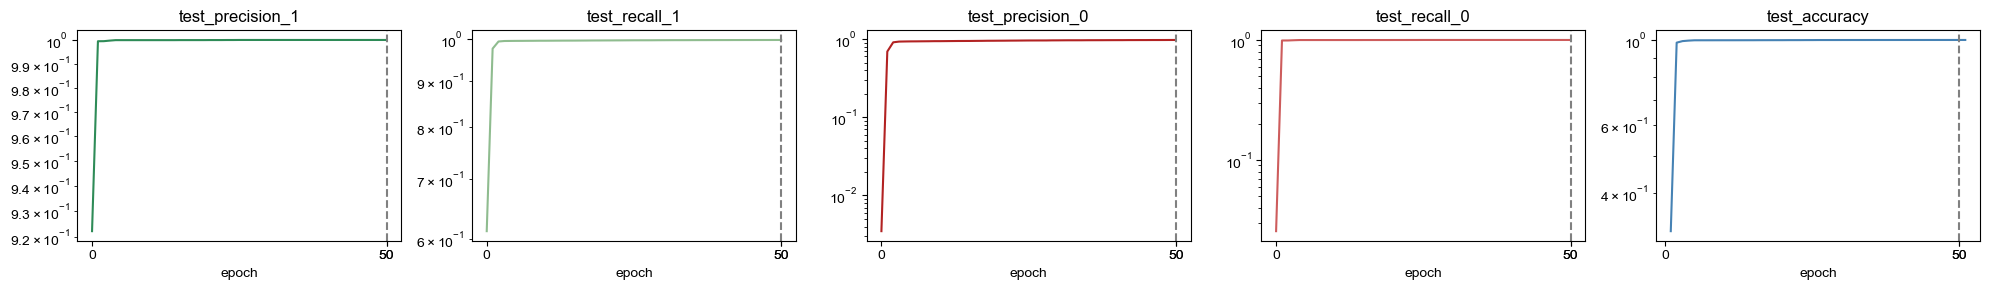

In [49]:
model = Classifier.load('../models/campylobacterota_v3.pkl')

def figure_1(model:Classifier, path:str=None, metrics:list=['test_precision_1', 'test_recall_1', 'test_precision_0', 'test_recall_0', 'test_accuracy']):
    
    colors = dict()
    colors['test_precision_1'] = 'seagreen'
    colors['test_recall_1'] = 'darkseagreen'
    colors['test_precision_0'] = 'firebrick'
    colors['test_recall_0'] = 'indianred'
    colors['test_accuracy'] = 'steelblue'

    fig, axes = plt.subplots(ncols=len(metrics), figsize=(4 * len(metrics), 3))
    
    for ax, metric in zip(axes, metrics):
        ax.set_title(metric)
        ax = sns.lineplot(x=np.arange(len(model.metrics[metric])), y=model.metrics[metric], label=metric, color=colors[metric], ax=ax, legend=False)
        ax.axvline(x=model.best_epoch, color='gray', linestyle='--')

        xticks = sorted(list(range(0, model.epochs + 1, 50)) + [model.best_epoch])
        ax.set_xticks(xticks, labels=xticks)
        ax.set_xlabel('epoch')
        ax.set_yscale('log')
        
    fig.tight_layout()
    plt.show()

figure_1(model)

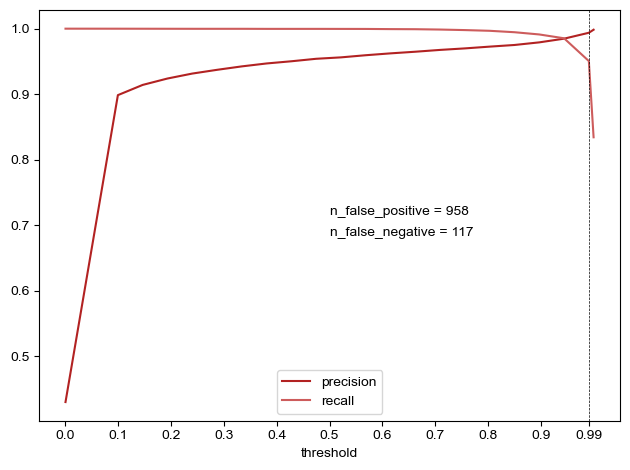

In [31]:
def figure_2(results_df, threshold:float=0.99):

    min_threshold = results_df.model_output_0.min() + 1e-3
    max_threshold = results_df.model_output_0.max() - 1e-3

    thresholds = [min_threshold] + list(np.linspace(0.1, 0.99, 20)) + [max_threshold]
    ax_df = pd.DataFrame(index=np.arange(len(thresholds)))
    ax_df['threshold'] = thresholds
    ax_df['precision'] = [precision(results_df, class_=0, threshold=threshold) for threshold in thresholds]
    ax_df['recall'] = [recall(results_df, class_=0, threshold=threshold) for threshold in thresholds]

    fig, ax = plt.subplots()

    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='precision', label='precision', color='firebrick')
    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='recall', label='recall', color='indianred')
    ax.axvline(threshold, color='black', linewidth=0.5, linestyle='--')

    n_fn = ((results_df.model_output_0 > threshold) & (results_df.label == 1)).sum()
    n_fp = ((results_df.model_output_0 <= threshold) & (results_df.label == 0)).sum()
    ax.text(0.5, 0.5, f'n_false_positive = {n_fp}', transform=ax.transAxes)
    ax.text(0.5, 0.45, f'n_false_negative = {n_fn}', transform=ax.transAxes)

    ax.set_ylabel('')
    x_ticks = sorted(list(np.arange(10) / 10) + [threshold])
    ax.set_xticks(x_ticks, labels=x_ticks)

    fig.tight_layout()
    plt.show()

figure_2(results_df, threshold=0.99)

# False negative is when a sequence is classified spurious, but is real (these are the most concerning)
# False positive is when a sequence is classified real, but is spurious. 

In [40]:
# Interested in the real sequences which the model thinks are spurious with high confidence. 
threshold = 0.99
results_df[(results_df.label == 1) & (results_df.model_output_0 > threshold)].to_csv('../data/results/false_positives.csv')

In [44]:
results_df.columns

Index(['model_label', 'model_output_0', 'model_output_1',
       'model_confusion_matrix', 'campylobacterota_v2_label',
       'campylobacterota_v2_output_0', 'campylobacterota_v2_output_1',
       'campylobacterota_v2_confusion_matrix', 'campylobacterota_v1_label',
       'campylobacterota_v1_output_0', 'campylobacterota_v1_output_1',
       'campylobacterota_v1_confusion_matrix', 'antifam_name', 'antifam_id',
       'product', 'ncbi_taxonomy_id', 'organism', 'seq', 'lineage',
       'library_entry_name', 'label', 'feature', 'contig_id', 'note', 'pseudo',
       'locus_tag', 'inference', 'experiment', 'ribosomal_slippage', 'strand',
       'start', 'stop', 'partial', 'continuous', 'translation_table',
       'codon_start', 'evidence_type', 'evidence_category', 'evidence_details',
       'evidence_source', 'used_pgap', 'copy_number', 'genome_id',
       'cluster_id'],
      dtype='object')